# Milestone 2

By December 15 you shall have implemented multiple baseline solutions to
your main text classification task. These should include both deep learning (DL) based methods
such as those introduced in Weeks 5-6 but also non-DL models such as those shown in Week 3.
Baselines can also include simple rule-based methods (e.g. keyword matching or regular expres-
sions). Each baseline should be evaluated both quantitatively and qualitatively, more details will
be provided in the lecture on text classification (Week 3)


## Load modules

In [49]:
import os
import pandas as pd
import conllu
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from torch import nn
import torch.nn.functional as F


## Load files

In [3]:
# Load the entire .conllu file into a Python variable
conllu_data = []
with open('Data/preprocessed_dataset.conllu', 'r', encoding='utf-8') as f:
    for line in f:
        conllu_data.append(line.strip())

# Display a sample of the loaded data (e.g., first 5 lines)
print("\n".join(conllu_data[:10]))

anns = pd.read_table('Data/annotations.txt', header=None)

# sent_id = 0_0
# text = And this Conservative strategy has produced the angry and desperate wing-nuts like the fellow who called reporters 'lying pieces of Sh*t' this week.
1	And	and	CCONJ	CC	_	None	None	_	_
2	this	this	DET	DT	Number=Sing|PronType=Dem	None	None	_	_
3	Conservative	Conservative	ADJ	JJ	Degree=Pos	None	None	_	_
4	strategy	strategy	NOUN	NN	Number=Sing	None	None	_	_
5	has	have	AUX	VBZ	Mood=Ind|Number=Sing|Person=3|Tense=Pres|VerbForm=Fin	None	None	_	_
6	produced	produce	VERB	VBN	Tense=Past|VerbForm=Part	None	None	_	_
7	the	the	DET	DT	Definite=Def|PronType=Art	None	None	_	_
8	angry	angry	ADJ	JJ	Degree=Pos	None	None	_	_


Format of sent_id : X_Y

Where X is the id of the comment, while Y is the id of the sentence.

Example : 2_3 means it's comment with id 2 and its 3rd sentence.

## First experiment: use of Naive Bayes classification (with original and pre-processed text)

1. Extraction of the comment only
2. Vectorization
3. Splitting into training and testing data
4. Training the model using different parameters
5. Evaluating the model


In [4]:
def extract_original_text(file_path):
    """
    Load the .conllu file and group sentences by comment ID, returning a list of concatenated texts.
    """
    comments_list = []
    current_comment_id = None
    current_text = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            
            if line.startswith('# sent_id ='):
                # Extract the comment ID (X) from 'sent_id = X_Y'
                sent_id = line.split('=')[1].strip()
                comment_id = sent_id.split('_')[0]

                # Check if we've moved to a new comment
                if current_comment_id is not None and comment_id != current_comment_id:
                    # Store the completed text for the previous comment
                    if current_text:
                        comments_list.append(" ".join(current_text))
                    current_text = []

                # Update the current comment ID
                current_comment_id = comment_id

            elif line.startswith('# text ='):
                # Extract the text for the current sentence
                sentence_text = line.split('=')[1].strip()
                current_text.append(sentence_text)

        # Add the last comment if any
        if current_comment_id is not None and current_text:
            comments_list.append(" ".join(current_text))

    return comments_list


In [5]:
def extract_preprocessed_text(file_path):
    """
    Load the .conllu file and group sentences by comment ID, returning a list of concatenated cleaned texts using lemmas.
    """
    comments_list = []
    current_comment_id = None
    current_text = []

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            line = line.strip()
            
            if line.startswith('# sent_id ='):
                # Extract the comment ID (X) from 'sent_id = X_Y'
                sent_id = line.split('=')[1].strip()
                comment_id = sent_id.split('_')[0]

                # Check if we've moved to a new comment
                if current_comment_id is not None and comment_id != current_comment_id:
                    # Store the completed text for the previous comment
                    if current_text:
                        comments_list.append(" ".join(current_text))
                    current_text = []

                current_comment_id = comment_id

            elif not line.startswith('#') and line:
                # Extract the lemma (3rd column)
                columns = line.split('\t')
                if len(columns) > 2:
                    lemma = columns[2].lower()  # Use the lemma column in lowercase
                    current_text.append(lemma)

        # Add the last comment if any
        if current_comment_id is not None and current_text:
            comments_list.append(" ".join(current_text))

    return comments_list


1. Extraction of the comments

In [83]:
file_path = 'Data/preprocessed_dataset.conllu'
original_list = extract_original_text(file_path)
original_list[:3]

["And this Conservative strategy has produced the angry and desperate wing-nuts like the fellow who called reporters 'lying pieces of Sh*t' this week. The fortunate thing is that reporters were able to report it and broadcast it - which may shake up a few folks who recognize a bit of themselves somewhere in there and do some reflecting. I live in hope.",
 "I commend Harper for holding the debates outside of a left-wing forum as this will help prevent the left from manipulating the debates to try to make Harper look bad. Indeed, we’ll finally have some fair debates. Trudeau is a coward and the only one who’s opposing this as he’s terrified about losing left-wing protection during the debates if the debates are held elsewhere. If Trudeau doesn’t have Chretien or Martin speaking for him or isn't currently in training to learn how to handle himself in a debate, he has May attending the debates to hold his little hand. If Trudeau can’t speak for himself or handle debates, how does he expect

In [87]:
preprocessed_list = extract_preprocessed_text(file_path)
preprocessed_list[:3]

["and this conservative strategy have produce the angry and desperate wing - nut like the fellow who call reporter 's lying piece of sh*tember ' this week . the fortunate thing be that reporter be able to report it and broadcast it - which may shake up a few folk who recognize a bit of themselves somewhere in there and do some reflect . i live in hope .",
 'i commend harper for hold the debate outside of a left - wing forum as this will help prevent the left from manipulate the debate to try to make harper look bad . indeed , we will finally have some fair debate . trudeau be a coward and the only one who be oppose this as he be terrified about lose left - wing protection during the debate if the debate be hold elsewhere . if trudeau do not have chretien or martin speak for he or be not currently in training to learn how to handle himself in a debate , he have may attend the debate to hold his little hand . if trudeau can not speak for himself or handle debate , how do he expect to run

In [88]:
print(len(original_list))

11999


In [101]:
assert len(anns) == len(original_list), "Annotations and original texts are misaligned!"
assert len(anns) == len(preprocessed_list), "Annotations and preprocessed texts are misaligned!"


In [142]:
import random

random_nr = random.randrange(0, 11999)
print(random_nr)

df_anno = pd.read_csv("./Data/compare_file.csv")

print(original_list[random_nr])

print(df_anno.loc[random_nr])

print(anns.loc[random_nr])

106
Harper did do one class act... He gave jack Layton a state funeral, whether deserved or not. He should have praised Flora MacDonald and attended her funeral. Some of his beliefs are, I think, a reaction to the Liberal Party arrogance that they are the sole arbiters of what Canadian values are and what our country stands for in the world. This time , I will not be giving the Conservatives my vote but don't know who will.
Unnamed: 0                                                           106
comment_text           Harper did do one class act... He gave jack La...
constructive_binary                                                    1
text_length                                                          423
avg_word_length                                                 4.435897
Name: 106, dtype: object
0    1
Name: 106, dtype: int64


### For original text

2. Vectorization (using TF-IDF)
3. Splitting into training and testing data
4. Training the Naive Bayes classifier
5. Evaluate the model

In [8]:
#2 Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(original_list)
y = anns

#3 Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#4 Training the Naive Bayes classifier
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}  # Adjust the range as needed
model = MultinomialNB()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train.values.ravel())

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

#5 Evaluate the model
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best alpha: 0.1
Best cross-validation accuracy: 0.6761
Accuracy: 0.6875

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.48      0.58      1086
           1       0.67      0.86      0.75      1314

    accuracy                           0.69      2400
   macro avg       0.70      0.67      0.67      2400
weighted avg       0.70      0.69      0.67      2400



### For preprocessed text

In [9]:
#2 Vectorization
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(preprocessed_list)
y = anns

#3 Splitting into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#4 Training the Naive Bayes classifier
param_grid = {'alpha': [0.1, 0.5, 1.0, 1.5, 2.0]}  # Adjust the range as needed
model = MultinomialNB()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train, y_train.values.ravel())

# Get the best model from GridSearchCV
best_model = grid_search.best_estimator_
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

#5 Evaluate the model
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Best alpha: 0.1
Best cross-validation accuracy: 0.6760
Accuracy: 0.6808333333333333

Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.47      0.57      1086
           1       0.66      0.85      0.75      1314

    accuracy                           0.68      2400
   macro avg       0.69      0.66      0.66      2400
weighted avg       0.69      0.68      0.67      2400



# Second experiment: Use Feature based models 

Idea: Use the features from the CONLL-U format to feed Machine Learning models (SVM, Random Forest, KNN and else) in order to classify the text

1. Extraction of the features
2. Splitting into training and testing data
3. Training the models using different parameters
4. Evaluating the models

In [10]:
def load_conllu_data(file_path):
    comments = {}
    
    with open(file_path, 'r', encoding='utf-8') as f:
        current_comment_id = None
        pos_counts = Counter()
        num_tokens = 0
        total_word_length = 0
        num_sentences = 0
        
        for line in f:
            line = line.strip()
            
            # Check if the line is a sentence ID line
            if line.startswith("# sent_id"):
                sent_id = line.split("= ")[1]
                current_comment_id = sent_id.split('_')[0]
                
                # Initialize a new comment entry if not already present
                if current_comment_id not in comments:
                    comments[current_comment_id] = {
                        'num_tokens': 0,
                        'total_word_length': 0,
                        'pos_counts': Counter(),
                        'num_sentences': 0
                    }
                    pos_counts = Counter()
                    num_tokens = 0
                    total_word_length = 0
                    num_sentences = 0

            # Check if the line is a text line
            elif line.startswith("# text"):
                text = line.split("= ")[1]

            # Process token lines
            elif line and not line.startswith("#"):
                columns = line.split("\t")
                if len(columns) >= 4:
                    token = columns[1]
                    pos_tag = columns[3]
                    
                    # Extract token-level features
                    word_length = len(token)
                    total_word_length += word_length
                    num_tokens += 1
                    pos_counts[pos_tag] += 1
            
            # End of a sentence block
            if line == "" and current_comment_id is not None:
                comments[current_comment_id]['num_tokens'] += num_tokens
                comments[current_comment_id]['total_word_length'] += total_word_length
                comments[current_comment_id]['pos_counts'].update(pos_counts)
                comments[current_comment_id]['num_sentences'] += 1

    # Convert the aggregated features to a DataFrame
    features = []
    for comment_id, data in comments.items():
        pos_counts = data['pos_counts']
        avg_word_length = data['total_word_length'] / data['num_tokens'] if data['num_tokens'] > 0 else 0
        
        feature_dict = {
            'comment_id': comment_id,
            'num_tokens': data['num_tokens'],
            'avg_word_length': avg_word_length,
            'num_sentences': data['num_sentences'],
            'num_nouns': pos_counts.get('NOUN', 0),
            'num_verbs': pos_counts.get('VERB', 0),
            'num_adjectives': pos_counts.get('ADJ', 0),
            'num_adverbs': pos_counts.get('ADV', 0),
            'num_pronouns': pos_counts.get('PRON', 0),
            'num_conjunctions': pos_counts.get('CCONJ', 0),
            'num_determiners': pos_counts.get('DET', 0),
        }
        features.append(feature_dict)
    
    df = pd.DataFrame(features)
    return df

1. Extraction of the features

In [11]:
file_path = 'Data/preprocessed_dataset.conllu'
features_conllu = load_conllu_data(file_path)

2. Splitting into training and testing data

In [12]:
X = features_conllu.drop(['comment_id'], axis=1)
y = anns 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

3. Training the models using different parameters
4. Evaluating the best models

In [13]:
# Define hyperparameter grids
param_grids = {
    'knn': {
        'n_neighbors': [3, 5, 10, 15,20,50,100],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
    },
    'rf': {
        'n_estimators': [10,25, 50, 100, 150],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    },
    'logisticregression': {
        'penalty': ['l2'],
        'C': [0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear']
    }
}

# Train and tune models
models = {
    'knn': KNeighborsClassifier(),
    'rf': RandomForestClassifier(random_state=42),
    'logisticregression': LogisticRegression()
}

best_models = {}

for model_name, model in models.items():
    print(f"\nTraining {model_name}...")
    grid_search = GridSearchCV(model, param_grids[model_name.lower()], cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train.values.ravel())
    
    print(f"Best Parameters for {model_name}: {grid_search.best_params_}")
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model

    # Evaluate on the test set
    y_pred = best_model.predict(X_test)
    print(f"\n{model_name} Accuracy:", accuracy_score(y_test, y_pred))
    print(f"\n{model_name} Classification Report:\n", classification_report(y_test, y_pred))


Training knn...
Best Parameters for knn: {'metric': 'manhattan', 'n_neighbors': 50, 'weights': 'uniform'}

knn Accuracy: 0.9075

knn Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      1086
           1       0.91      0.92      0.92      1314

    accuracy                           0.91      2400
   macro avg       0.91      0.91      0.91      2400
weighted avg       0.91      0.91      0.91      2400


Training rf...
Best Parameters for rf: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 50}

rf Accuracy: 0.9233333333333333

rf Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.92      0.92      1086
           1       0.93      0.93      0.93      1314

    accuracy                           0.92      2400
   macro avg       0.92      0.92      0.92      2400
weighted avg       0.92      0.92      0.92      2400


Training logisticregress

/Users/gerhardkarbeutz/NLP-DetecConstComm-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/gerhardkarbeutz/NLP-DetecConstComm-project/venv/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https

### Model Performance Comparison

| Classifier              | Accuracy | Precision (0) | Recall (0) | F1-score (0) | Precision (1) | Recall (1) | F1-score (1) | Macro Avg Precision | Macro Avg Recall | Macro Avg F1-score |
|-------------------------|----------|----------------|-------------|---------------|----------------|-------------|---------------|---------------------|-------------------|---------------------|
| **Naive Bayes on original data**         | 0.6875   | 0.74           | 0.48        | 0.58          | 0.67           | 0.86        | 0.75          | 0.70                | 0.67              | 0.67                |
| **Naive Bayes on preprocessed data**         | 0.6808   | 0.73           | 0.47        | 0.57         | 0.66           | 0.85        | 0.75          | 0.69                | 0.66              | 0.66                |
| **K-Nearest Neighbors** | 0.9075   | 0.90           | 0.89        | 0.90          | 0.91           | 0.92        | 0.92          | 0.91                | 0.91              | 0.91                |
| **Random Forest**       | 0.9233   | 0.91           | 0.92        | 0.92          | 0.93           | 0.93        | 0.93          | 0.92                | 0.92              | 0.92                |
| **Logistic Regression** | 0.91     | 0.87           | 0.94        | 0.90          | 0.95           | 0.89        | 0.92          | 0.91                | 0.91              | 0.91                |

---

### Explanation of the Columns:
- **Accuracy**: Overall accuracy of the model.
- **Precision (0)**, **Recall (0)**, **F1-score (0)**: Metrics for class **0**.
- **Precision (1)**, **Recall (1)**, **F1-score (1)**: Metrics for class **1**.
- **Macro Avg Precision**, **Macro Avg Recall**, **Macro Avg F1-score**: Averages of precision, recall, and F1-score for both classes

### Another interesting question is where do these model fails to correctly classify the texts, let's print some example from the Random Forest Classifier

In [14]:
# Retain 'comment_id' for reference
X = features_conllu.drop(['comment_id'], axis=1)
comment_ids = features_conllu['comment_id']

# Split data, retaining comment IDs in the test set
X_train, X_test, y_train, y_test, comment_ids_train, comment_ids_test = train_test_split(
    X, y, comment_ids, test_size=0.2, random_state=42)

# Retrain the best RF model with specified parameters
best_rf = RandomForestClassifier(max_depth=10, min_samples_split=2, n_estimators=50, random_state=42)
best_rf.fit(X_train, y_train.values.ravel())

# Predict on the test set
y_pred = best_rf.predict(X_test)
y_test_array = y_test.values.ravel()
# Identify misclassified indices
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test_array, y_pred)) if true != pred]

# Group misclassified samples by true class
misclassified_by_category = {0: [], 1: []}

for idx in misclassified_indices:
    true_class = y_test_array[idx]
    if true_class in misclassified_by_category:
        misclassified_by_category[true_class].append(comment_ids_test.iloc[idx])

# Print up to 3 misclassified comment IDs for each category
print("Misclassified examples:\n")
for category, comment_ids in misclassified_by_category.items():
    category_name = "constructive" if category == 0 else "not constructive"
    print(f"Category '{category_name}' misclassified as being the opposite:\n")
    for i, comment_id in enumerate(comment_ids[:3]):
        print(f"- {original_list[int(comment_id)]}")
    print()

Misclassified examples:

Category 'constructive' misclassified as being the opposite:

- Trump is irrelevant. The US citizenry needs to clean out the corrupt government as required every several generations. It would have been Perot or Buchanan at another time. Get rid of Trump, and there will be a different name with the same agenda. And the media and establishment will oppose him or her too.
- Until the Globe editorial board can explain why they endorsed the Harper government time and time again and at the same they are reporting on the corruption and lies and scams. These editorials just look foolish to me. Now their a problem with the Harper government?
- '........... that small symbolic acts have great power, ..........'. Yeah, symbology like the fact that some of the strongest proponents for massive lifestyle change just happen to be amongst the biggest carbon gluttons on the planet. You listening Dave?

Category 'not constructive' misclassified as being the opposite:

- Margaret

# Now Onto Deep Learning solutions!

In [59]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

ModuleNotFoundError: No module named 'tensorflow'

In [ ]:
# Dataser preprocessed
X = vectorizer.fit_transform(preprocessed_list)
y = anns

# Training data for Deep Learning
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define model architecture
nn_model = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]), # Input layer
    Dropout(0.2),  # Dropout to avoid overfitting
    Dense(64, activation='relu'),  # Intermediate layer
    Dropout(0.2),  # Dropout to avoid overfitting
    Dense(32, activation='relu'),  # Intermediate layer
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

/Users/saitohiraga/Documents/GitHub/NLP-DetecConstComm-project/venv/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile the model
nn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'precision', 'recall'])

In [ ]:
# Train the model
nn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.7007 - loss: 0.5128 - precision: 0.6740 - recall: 0.9226 - val_accuracy: 0.8661 - val_loss: 0.3013 - val_precision: 0.8942 - val_recall: 0.8537
Epoch 2/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9620 - loss: 0.1122 - precision: 0.9677 - recall: 0.9616 - val_accuracy: 0.8562 - val_loss: 0.3519 - val_precision: 0.8523 - val_recall: 0.8884
Epoch 3/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9895 - loss: 0.0365 - precision: 0.9937 - recall: 0.9871 - val_accuracy: 0.8578 - val_loss: 0.5207 - val_precision: 0.8383 - val_recall: 0.9134
Epoch 4/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9984 - loss: 0.0066 - precision: 0.9994 - recall: 0.9976 - val_accuracy: 0.8510 - val_loss: 0.6279 - val_precision: 0.8359 - val_recall: 0.9018
Epoch 5/10
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - accuracy: 0.9995 - loss: 0.0020 - precision: 0.9997 - recall: 0.9995 - val_accuracy: 0.8557 - val_los

In [ ]:
# Evaluate the model
loss, accuracy, precision, recall = nn_model.evaluate(X_test, y_test)

f1_score = 2 * (precision * recall) / (precision + recall)

print(f"Loss: {loss:.4f}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8415 - loss: 0.8937 - precision: 0.8629 - recall: 0.8496
Loss: 0.9024
Accuracy: 0.8446
Precision: 0.8673
Recall: 0.8455


# Trying Bert

In [157]:
import transformers
from transformers import BertTokenizer, AutoTokenizer

In [ ]:

from sklearn.model_selection import train_test_split as split



ValueError: too many values to unpack (expected 2)

In [161]:
from sklearn.model_selection import train_test_split

# First split: Divide the original data into training+validation and test sets
X_train_val_bert, X_test_bert, y_train_val_bert, y_test_bert = train_test_split(
    original_list, anns, test_size=0.2, random_state=42
)

# Second split: Divide the training+validation set into training and validation sets
X_train_bert, X_val_bert, y_train_bert, y_val_bert = train_test_split(
    X_train_val_bert, y_train_val_bert, test_size=0.1, random_state=42
)

# Print the sizes of each set
print(f"Training size: {len(X_train_bert)}, Validation size: {len(X_val_bert)}, Test size: {len(X_test_bert)}")


Training size: 8639, Validation size: 960, Test size: 2400


In [162]:
import torch

# Convert labels to tensors
y_train_bert = torch.tensor(y_train_bert.values, dtype=torch.long)
y_val_bert = torch.tensor(y_val_bert.values, dtype=torch.long)
y_test_bert = torch.tensor(y_test_bert.values, dtype=torch.long)


Unlike traditional NLP pipelines, BERT's tokenizer requires no additional preprocessing:

You don’t need to remove stopwords because BERT can handle their contextual importance.
You don’t need to lemmatize or stem because subwords inherently capture morphological variations (e.g., "run" and "running").
Case sensitivity is handled if you're using the case-sensitive version of BERT.
This makes the process simpler and ensures that the model works with raw input text.

In [163]:
from transformers import BertTokenizer

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# Tokenize the data
def tokenize_texts(texts, tokenizer, max_length=128):
    return tokenizer(
        texts,
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="pt"
    )

train_encodings = tokenize_texts(X_train_bert, tokenizer)
val_encodings = tokenize_texts(X_val_bert, tokenizer)
test_encodings = tokenize_texts(X_test_bert, tokenizer)


In [75]:
from transformers import BertForSequenceClassification, AutoModelForSequenceClassification, TrainingArguments, RobertaForSequenceClassification, Trainer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [164]:
from torch.utils.data import Dataset

class CommentDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": self.labels[idx],
        }

# Create datasets
train_dataset = CommentDataset(train_encodings, y_train_bert)
val_dataset = CommentDataset(val_encodings, y_val_bert)
test_dataset = CommentDataset(test_encodings, y_test_bert)




In [165]:
from transformers import BertForSequenceClassification

# Load BERT model for classification
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [166]:
from transformers import Trainer, TrainingArguments

# Define training arguments
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    evaluation_strategy="epoch",
    save_strategy="epoch",
)

# Define the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)


/Users/gerhardkarbeutz/NLP-DetecConstComm-project/venv/lib/python3.10/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [167]:
trainer.train() 


  0%|          | 0/3240 [00:00<?, ?it/s]

{'loss': 0.7277, 'grad_norm': 4.439280033111572, 'learning_rate': 1.0000000000000002e-06, 'epoch': 0.01}
{'loss': 0.7228, 'grad_norm': 8.950873374938965, 'learning_rate': 2.0000000000000003e-06, 'epoch': 0.02}
{'loss': 0.6769, 'grad_norm': 3.9286797046661377, 'learning_rate': 3e-06, 'epoch': 0.03}
{'loss': 0.6457, 'grad_norm': 8.793628692626953, 'learning_rate': 4.000000000000001e-06, 'epoch': 0.04}
{'loss': 0.5729, 'grad_norm': 5.118696689605713, 'learning_rate': 5e-06, 'epoch': 0.05}
{'loss': 0.521, 'grad_norm': 9.963205337524414, 'learning_rate': 6e-06, 'epoch': 0.06}
{'loss': 0.5126, 'grad_norm': 7.262749671936035, 'learning_rate': 7.000000000000001e-06, 'epoch': 0.06}
{'loss': 0.4464, 'grad_norm': 18.62522315979004, 'learning_rate': 8.000000000000001e-06, 'epoch': 0.07}
{'loss': 0.4239, 'grad_norm': 7.297521591186523, 'learning_rate': 9e-06, 'epoch': 0.08}
{'loss': 0.3768, 'grad_norm': 9.70535659790039, 'learning_rate': 1e-05, 'epoch': 0.09}
{'loss': 0.3766, 'grad_norm': 8.3395929

  0%|          | 0/60 [00:00<?, ?it/s]

{'eval_loss': 0.23229672014713287, 'eval_runtime': 7.0351, 'eval_samples_per_second': 136.459, 'eval_steps_per_second': 8.529, 'epoch': 1.0}
{'loss': 0.2136, 'grad_norm': 0.5451074242591858, 'learning_rate': 3.9233576642335764e-05, 'epoch': 1.01}
{'loss': 0.3003, 'grad_norm': 70.72721862792969, 'learning_rate': 3.905109489051095e-05, 'epoch': 1.02}
{'loss': 0.4374, 'grad_norm': 15.410810470581055, 'learning_rate': 3.886861313868613e-05, 'epoch': 1.03}
{'loss': 0.3728, 'grad_norm': 9.219738960266113, 'learning_rate': 3.868613138686132e-05, 'epoch': 1.04}
{'loss': 0.2057, 'grad_norm': 4.477297306060791, 'learning_rate': 3.85036496350365e-05, 'epoch': 1.05}
{'loss': 0.34, 'grad_norm': 1.0985395908355713, 'learning_rate': 3.832116788321168e-05, 'epoch': 1.06}
{'loss': 0.1282, 'grad_norm': 0.7224826216697693, 'learning_rate': 3.813868613138686e-05, 'epoch': 1.06}
{'loss': 0.1826, 'grad_norm': 0.3357544541358948, 'learning_rate': 3.795620437956204e-05, 'epoch': 1.07}
{'loss': 0.2714, 'grad_n

  0%|          | 0/60 [00:00<?, ?it/s]

{'eval_loss': 0.19398297369480133, 'eval_runtime': 6.839, 'eval_samples_per_second': 140.372, 'eval_steps_per_second': 8.773, 'epoch': 2.0}
{'loss': 0.2459, 'grad_norm': 4.240015983581543, 'learning_rate': 1.9525547445255476e-05, 'epoch': 2.01}
{'loss': 0.1069, 'grad_norm': 0.8892775177955627, 'learning_rate': 1.934306569343066e-05, 'epoch': 2.02}
{'loss': 0.0925, 'grad_norm': 17.839080810546875, 'learning_rate': 1.916058394160584e-05, 'epoch': 2.03}
{'loss': 0.2696, 'grad_norm': 4.107739448547363, 'learning_rate': 1.897810218978102e-05, 'epoch': 2.04}
{'loss': 0.0876, 'grad_norm': 0.11767221987247467, 'learning_rate': 1.8795620437956205e-05, 'epoch': 2.05}
{'loss': 0.1582, 'grad_norm': 0.12730038166046143, 'learning_rate': 1.861313868613139e-05, 'epoch': 2.06}
{'loss': 0.2463, 'grad_norm': 0.17337104678153992, 'learning_rate': 1.843065693430657e-05, 'epoch': 2.06}
{'loss': 0.4185, 'grad_norm': 18.36329460144043, 'learning_rate': 1.8248175182481753e-05, 'epoch': 2.07}
{'loss': 0.1457, 

  0%|          | 0/60 [00:00<?, ?it/s]

{'eval_loss': 0.2287292629480362, 'eval_runtime': 6.8262, 'eval_samples_per_second': 140.634, 'eval_steps_per_second': 8.79, 'epoch': 3.0}
{'train_runtime': 888.4348, 'train_samples_per_second': 29.172, 'train_steps_per_second': 3.647, 'train_loss': 0.24201513725666352, 'epoch': 3.0}


TrainOutput(global_step=3240, training_loss=0.24201513725666352, metrics={'train_runtime': 888.4348, 'train_samples_per_second': 29.172, 'train_steps_per_second': 3.647, 'total_flos': 1704762305441280.0, 'train_loss': 0.24201513725666352, 'epoch': 3.0})

In [169]:
# Make predictions on the test set
predictions = trainer.predict(test_dataset)

# Extract predictions and calculate accuracy
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1)
accuracy = (predicted_labels == y_test_bert).sum().item() / len(y_test_bert)

print(f"Test Accuracy: {accuracy:.4f}")


  0%|          | 0/150 [00:00<?, ?it/s]

Test Accuracy: 1208.8350


In [172]:
print(predictions.predictions[0], y_test_bert[0])


[ 2.602404  -2.5929542] tensor([0])


In [174]:
predicted_labels = torch.argmax(torch.tensor(predictions.predictions), axis=1)  # Shape: [2400]


In [177]:
y_test_bert = y_test_bert.view(-1)  # Shape: [2400]



In [179]:
predicted_labels = predicted_labels.to(dtype=torch.long)
y_test_bert = y_test_bert.to(dtype=torch.long)


In [181]:
accuracy = (predicted_labels == y_test_bert).sum().item() / len(y_test_bert)
print(f"Test Accuracy: {accuracy:.4f}")


Test Accuracy: 0.9363


In [183]:
print(f"Predicted Labels Shape: {predicted_labels.shape}")
print(f"y_test_bert Shape: {y_test_bert.shape}")
print(f"Sample Predictions: {predicted_labels[:5]}")
print(f"Sample Ground Truth: {y_test_bert[:5]}")


Predicted Labels Shape: torch.Size([2400])
y_test_bert Shape: torch.Size([2400])
Sample Predictions: tensor([0, 1, 0, 1, 1])
Sample Ground Truth: tensor([0, 0, 0, 1, 1])


In [185]:
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support

# Assuming predicted_labels and y_test_bert are already defined and aligned

# Convert tensors to NumPy arrays for compatibility with sklearn
predicted_labels_np = predicted_labels.cpu().numpy()
y_test_bert_np = y_test_bert.cpu().numpy()

# Calculate metrics
accuracy = accuracy_score(y_test_bert_np, predicted_labels_np)
precision, recall, f1, _ = precision_recall_fscore_support(y_test_bert_np, predicted_labels_np, average=None, labels=[0, 1])
macro_avg = precision_recall_fscore_support(y_test_bert_np, predicted_labels_np, average='macro')

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision (0): {precision[0]:.4f}, Recall (0): {recall[0]:.4f}, F1-score (0): {f1[0]:.4f}")
print(f"Precision (1): {precision[1]:.4f}, Recall (1): {recall[1]:.4f}, F1-score (1): {f1[1]:.4f}")
print(f"Macro Avg Precision: {macro_avg[0]:.4f}, Macro Avg Recall: {macro_avg[1]:.4f}, Macro Avg F1-score: {macro_avg[2]:.4f}")

# Optional: Generate and display a classification report
report = classification_report(y_test_bert_np, predicted_labels_np, target_names=['Class 0', 'Class 1'])
print("\nClassification Report:")
print(report)


Accuracy: 0.9363
Precision (0): 0.9214, Recall (0): 0.9392, F1-score (0): 0.9302
Precision (1): 0.9490, Recall (1): 0.9338, F1-score (1): 0.9413
Macro Avg Precision: 0.9352, Macro Avg Recall: 0.9365, Macro Avg F1-score: 0.9358

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.92      0.94      0.93      1086
     Class 1       0.95      0.93      0.94      1314

    accuracy                           0.94      2400
   macro avg       0.94      0.94      0.94      2400
weighted avg       0.94      0.94      0.94      2400



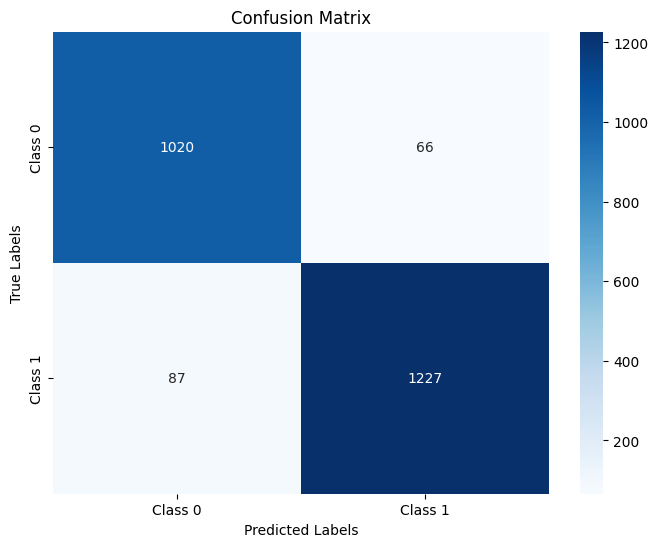

Class Distribution in Test Set:
Class 0: 1086 samples
Class 1: 1314 samples


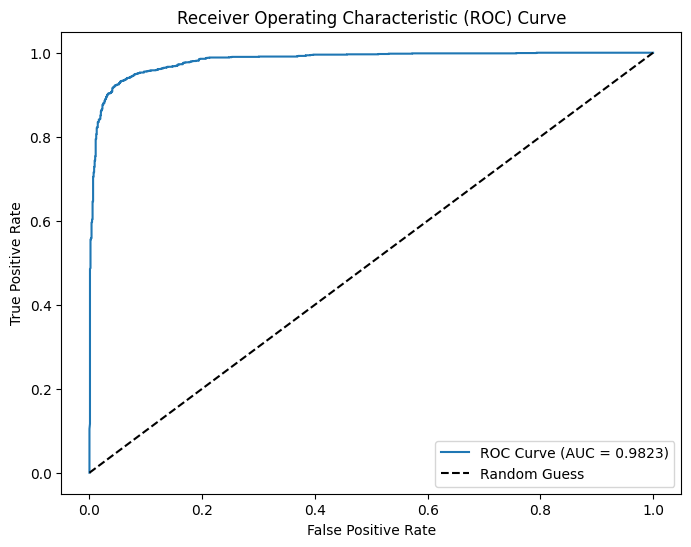

In [186]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

# Assuming y_test_bert and predictions.predictions are defined
# Convert tensors to NumPy arrays
y_test_bert_np = y_test_bert.cpu().numpy()  # Ground truth labels
predicted_labels_np = predicted_labels.cpu().numpy()  # Predicted class labels

# Confusion Matrix
cm = confusion_matrix(y_test_bert_np, predicted_labels_np)

# Visualize the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Class Distribution in Test Set
class_distribution = {label: count for label, count in zip(*np.unique(y_test_bert_np, return_counts=True))}

# Display Class Distribution
print("Class Distribution in Test Set:")
for cls, count in class_distribution.items():
    print(f"Class {cls}: {count} samples")

# ROC-AUC and ROC Curve
y_test_bert_prob = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].cpu().numpy()  # Probability for Class 1
fpr, tpr, thresholds = roc_curve(y_test_bert_np, y_test_bert_prob)
roc_auc = roc_auc_score(y_test_bert_np, y_test_bert_prob)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()
